In [37]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
from helper_functions import *
import seaborn as sns
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
import warnings
warnings.filterwarnings('ignore')

# SPZ Mini Challenge 1 
### Data
Für diese Challenge haben wir die Daten von [SwissGrid](www.swissgrid.ch) verwendet, die hier zu finden sind: [Energie Übersicht](https://www.swissgrid.ch/en/home/operation/grid-data/transmission.html). 

Von diesen Daten verwenden wir die 15-Minuten-Auflösung, da dies die einzige Auflösung ist, die alle Informationen enthält, die wir benötigen. Um Rechenzeit zu sparen, werden die Daten auf eine 4-Stunden-Auflösung hochgerechnet. Für bestimmte Aufgaben werden wir eine tägliche oder monatliche Auflösung verwenden.

### Budget, Usage und Bilanz
Um diese Features zu erzeugen, gehen wir wie folgt vor:

#### Budget

Hinzufügen von `"Summe produzierte Energie Regelblock Schweiz"` und `"Import"`
#### Verbrauch

Addition von `"Summe endverbrauchte Energie Regelblock Schweiz"` und `"Export"`
#### Bilanz

Subtraktion von `"Budget"` - `"Verbrauch"`

## Data Loading und  Data Cleaning
In den nächsten Schritten werden wir die Kopfzeilen bereinigen, die Typen bestimmter Spalten festlegen, die Daten abfragen und die neuen Funktionen generieren.

In [38]:
# Read in Data:
data = load_data('EnergieUebersichtCH-*', 'Zeitreihen0h15')
data.head()

,Unnamed: 0,Summe endverbrauchte Energie Regelblock Schweiz\nTotal energy consumed by end users in the Swiss controlblock,Summe produzierte Energie Regelblock Schweiz\nTotal energy production Swiss controlblock,Summe verbrauchte Energie Regelblock Schweiz\nTotal energy consumption Swiss controlblock,Netto Ausspeisung aus dem Übertragungsnetz Schweiz\nNet outflow of the Swiss transmission grid,Vertikale Einspeisung ins Übertragungsnetz Schweiz\nGrid feed-in Swiss transmission grid,Positive Sekundär-Regelenergie\nPositive secundary control energy,Negative Sekundär-Regelenergie\nNegative secundary control energy,Positive Tertiär-Regelenergie\nPositive tertiary control energy,Negative Tertiär-Regelenergie\nNegative tertiary control energy,...,"Produktion Kantone OW, NW, UR\nProduction Cantons OW, NW, UR","Verbrauch Kantone OW, NW, UR\nConsumption Cantons OW, NW, UR","Produktion Kantone GE, VD\nProduction Cantons GE, VD","Verbrauch Kantone GE, VD\nConsumption Cantons GE, VD","Produktion Kantone SH, ZH\nProduction Cantons SH, ZH","Verbrauch Kantone SH, ZH\nConsumption Cantons SH, ZH",Produktion Kantonsübergreifend\nProduction across Cantons,Verbrauch Kantonsübergreifend\nConsumption across Cantons,Produktion Regelzone CH - Ausländische Gebiete\nProduction control area CH - foreign territories,Verbrauch Regelzone CH - Ausländische Gebiete\nConsumption control area CH - foreign territories
0,Zeitstempel,kWh,kWh,kWh,kWh,kWh,kWh,kWh,kWh,kWh,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-01 00:15:00,1829965.532,1328840.011,1923497.62025,535032.369,1051663.768,0,-42000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-01 00:30:00,1715172.867,1310517.237,1905593.89825,531262.971,1030932.571,0,-64000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-01 00:45:00,1732581.748,1330421.997,1919726.30525,531174.589,1054606.836,0,-52000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-01 01:00:00,1706689.208,1303333.914,1891833.42625,534226.167,1036944.249,0,-51000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# Clean Dataframe (Rename columns etc.)
data_clean = data_cleaning(data.copy())
data_clean.head()

,Summe endverbrauchte Energie Regelblock Schweiz,Summe produzierte Energie Regelblock Schweiz,Summe verbrauchte Energie Regelblock Schweiz,Netto Ausspeisung aus dem Übertragungsnetz Schweiz,Vertikale Einspeisung ins Übertragungsnetz Schweiz,Positive Sekundär-Regelenergie,Negative Sekundär-Regelenergie,Positive Tertiär-Regelenergie,Negative Tertiär-Regelenergie,Verbundaustausch CH->AT,...,"Produktion Kantone OW, NW, UR","Verbrauch Kantone OW, NW, UR","Produktion Kantone GE, VD","Verbrauch Kantone GE, VD","Produktion Kantone SH, ZH","Verbrauch Kantone SH, ZH",Produktion Kantonsübergreifend,Verbrauch Kantonsübergreifend,Produktion Regelzone CH - Ausländische Gebiete,Verbrauch Regelzone CH - Ausländische Gebiete
Zeitstempel,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:15:00,1829965.532,1328840.011,1923497.62025,535032.369,1051663.768,0,-42000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:30:00,1715172.867,1310517.237,1905593.89825,531262.971,1030932.571,0,-64000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:45:00,1732581.748,1330421.997,1919726.30525,531174.589,1054606.836,0,-52000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 01:00:00,1706689.208,1303333.914,1891833.42625,534226.167,1036944.249,0,-51000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 01:15:00,1722372.541,1350111.973,1919922.64075,501786.775,1065655.805,0,-24000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Change from CET to UTC:
data_clean_loc = localize_time(data_clean.copy())
data_clean_loc.head()

,Summe endverbrauchte Energie Regelblock Schweiz,Summe produzierte Energie Regelblock Schweiz,Summe verbrauchte Energie Regelblock Schweiz,Netto Ausspeisung aus dem Übertragungsnetz Schweiz,Vertikale Einspeisung ins Übertragungsnetz Schweiz,Positive Sekundär-Regelenergie,Negative Sekundär-Regelenergie,Positive Tertiär-Regelenergie,Negative Tertiär-Regelenergie,Verbundaustausch CH->AT,...,"Produktion Kantone OW, NW, UR","Verbrauch Kantone OW, NW, UR","Produktion Kantone GE, VD","Verbrauch Kantone GE, VD","Produktion Kantone SH, ZH","Verbrauch Kantone SH, ZH",Produktion Kantonsübergreifend,Verbrauch Kantonsübergreifend,Produktion Regelzone CH - Ausländische Gebiete,Verbrauch Regelzone CH - Ausländische Gebiete
Zeitstempel,,,,,,,,,,,,,,,,,,,,,
2008-12-31 23:15:00+00:00,1829965.532,1328840.011,1923497.62025,535032.369,1051663.768,0,-42000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12-31 23:30:00+00:00,1715172.867,1310517.237,1905593.89825,531262.971,1030932.571,0,-64000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12-31 23:45:00+00:00,1732581.748,1330421.997,1919726.30525,531174.589,1054606.836,0,-52000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:00:00+00:00,1706689.208,1303333.914,1891833.42625,534226.167,1036944.249,0,-51000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:15:00+00:00,1722372.541,1350111.973,1919922.64075,501786.775,1065655.805,0,-24000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
data_selected = create_features(data_clean_loc, type_='normal')
data_selected

,Strombilanz Schweiz,Strombudget Schweiz,Stromverbrauch Schweiz
Zeitstempel,,,
2008-12-31 23:15:00+00:00,85324.479,2499290.011,2413965.532
2008-12-31 23:30:00+00:00,185394.37,2454567.237,2269172.867
2008-12-31 23:45:00+00:00,200990.249,2496571.997,2295581.748
2009-01-01 00:00:00+00:00,192894.706,2463583.914,2270689.208
2009-01-01 00:15:00+00:00,199339.432,2522711.973,2323372.541
...,...,...,...
2020-12-31 22:00:00+00:00,223057.035,2614793.333,2391736.298
2020-12-31 22:15:00+00:00,176364.238,2554526.509,2378162.271
2020-12-31 22:30:00+00:00,182054.51,2507860.154,2325805.644


In [42]:
# Daten sampeln auf andere Timestamps.
data_m = data_selected.resample('M').mean()
data_4h = data_selected.resample('4h').mean()
data_d = data_selected.resample('1D').mean()

### Explorative Datenanalyse
#### Monatlich
##### Linienplots

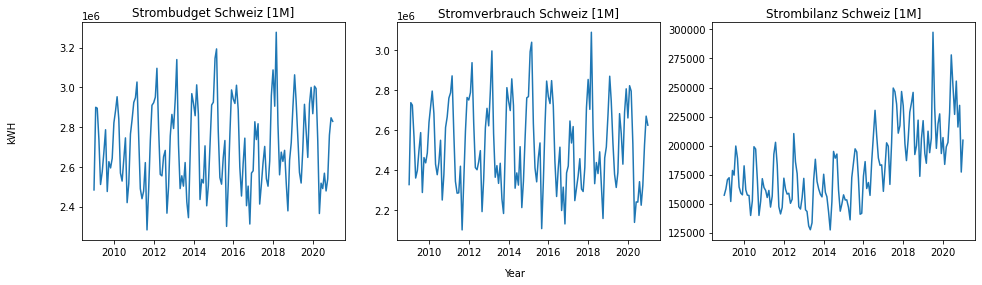

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(16,4), sharex=True)
axs[0].plot(data_m['Strombudget Schweiz'])
axs[0].set_title('Strombudget Schweiz [1M]')
axs[1].plot(data_m['Stromverbrauch Schweiz'])
axs[1].set_title('Stromverbrauch Schweiz [1M]')
axs[2].plot(data_m['Strombilanz Schweiz'])
axs[2].set_title('Strombilanz Schweiz [1M]')
fig.text(0.5, 0.00, 'Year', ha='center')
fig.text(0.06, 0.5, 'kWH', va='center', rotation='vertical')
plt.show()

##### Autokorrelation [1M]
Zunächst wollen wir uns die jährliche Saisonalität ansehen. Dies ist am einfachsten mit einer monatlichen Auflösung.

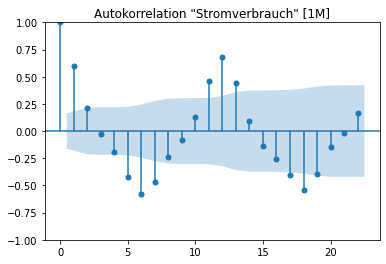

In [44]:
plot_acf(data_m['Stromverbrauch Schweiz'], title='Autokorrelation "Stromverbrauch" [1M]')
plt.show()

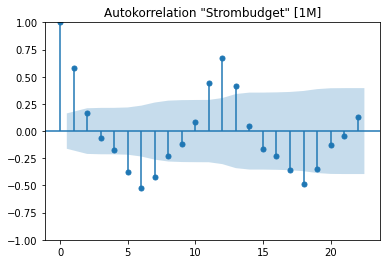

In [45]:
plot_acf(data_m['Strombudget Schweiz'], title='Autokorrelation "Strombudget" [1M]')
plt.show()

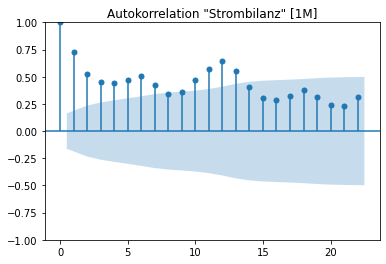

In [46]:
plot_acf(data_m['Strombilanz Schweiz'], title='Autokorrelation "Strombilanz" [1M]')
plt.show()

Wie erwartet, ist eine jährliche Saisonabhängigkeit des Strombudgets und des Stromverbrauchs zu beobachten. Auch die Bilanz scheint interessanterweise einem schwachen Jahreszyklus zu folgen. Wir können sehen, dass sie alle eine Spitze bei der Verzögerung von etwa 12 haben, was einem Jahr in Monaten entspricht.

#### 4 Stunden Daten
Bei den 4-Stunden-Daten werden wir uns mehr mit der täglichen Saisonalität befassen. Um diesen klarer zu sehen, schauen wir also jeweils nur mit einer Unterstichprobe der Gesamtdaten.

In [47]:
ROWS_TO_SHOW = 24

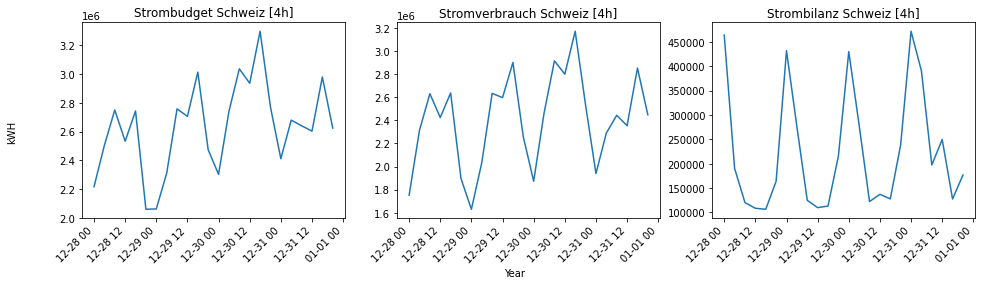

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(16,4), sharex=True)
axs[0].plot(data_4h['Strombudget Schweiz'].tail(ROWS_TO_SHOW))
axs[0].set_title('Strombudget Schweiz [4h]')
axs[1].plot(data_4h['Stromverbrauch Schweiz'].tail(ROWS_TO_SHOW))
axs[1].set_title('Stromverbrauch Schweiz [4h]')
axs[2].plot(data_4h['Strombilanz Schweiz'].tail(ROWS_TO_SHOW))
axs[2].set_title('Strombilanz Schweiz [4h]')
fig.autofmt_xdate(rotation=45)
fig.text(0.5, 0.00, 'Year', ha='center')
fig.text(0.06, 0.5, 'kWH', va='center', rotation='vertical')
plt.show()

#### 4-Stunden Daten, gemittelt über mehrere Jahre

In [49]:
data_4h_average = data_4h.copy()
data_4h_average['datetime'] = data_4h_average.index.strftime("%d-%m %H:%M")
data_4h_average = data_4h_average.groupby(data_4h_average.datetime).mean()

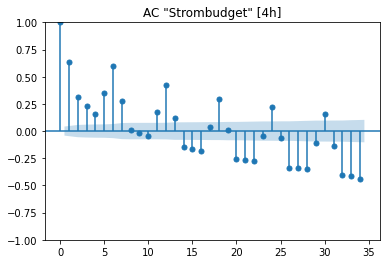

In [50]:
plot_acf(data_4h_average['Strombudget Schweiz'], title='AC "Strombudget" [4h]')
plt.show()

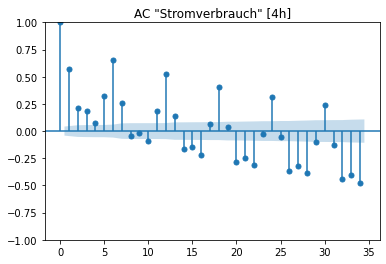

In [51]:
plot_acf(data_4h_average['Stromverbrauch Schweiz'], title='AC "Stromverbrauch" [4h]')
plt.show()

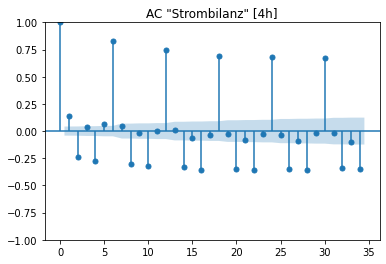

In [52]:
plot_acf(data_4h_average['Strombilanz Schweiz'], title='AC "Strombilanz" [4h]')
plt.show()

Es hat sich gelohnt, sich das auch unabhängig vom Jahr anzuschauen. Wir sehen hier den Lag von 6, was einem Tag entspricht.

### Saisonale Plots

Wir wollen unsere drei Messgrössen 'Stromverbrauch Schweiz', 'Strombudget Schweiz' und 'Strombilanz Schweiz' auf optische Unterschiede der Jährlichen Saisonalität untersuchen. 

Würden die Varianzen mit steigendem Erwartungswert zunehmen, deutet das darauf hin, dass ein multiplikatives Modell für die längerfristige Vorhersage potenziell besser geeignet wäre. Ist die Varianz unkorreliert vom Erwartungswert konstant, könnte hingegen ein additives Modell die bessere Wahl sein.

#### Stromverbrauch Schweiz

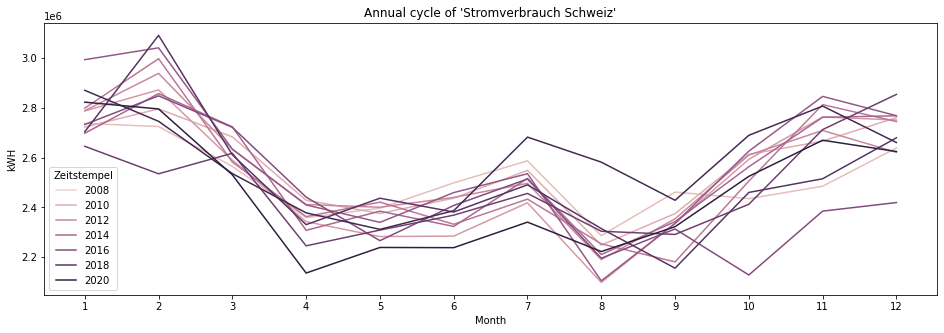

In [53]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(data=data_m, 
             x=data_m.index.month, 
             y="Stromverbrauch Schweiz", 
             hue=data_m.index.year)
ax.set_xticks(range(1,13))
plt.title("Annual cycle of 'Stromverbrauch Schweiz'")
plt.xlabel("Month")
plt.ylabel("kWH")
plt.show()

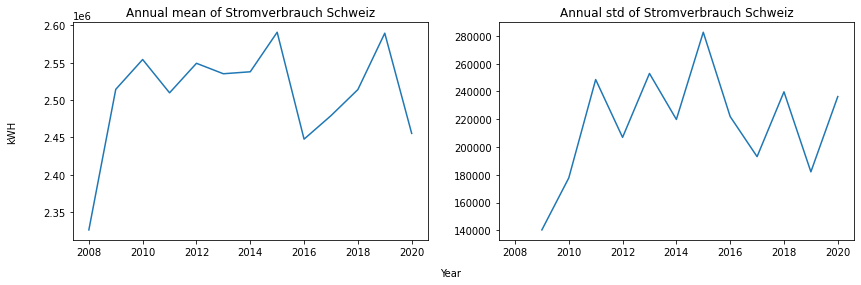

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4), sharex=True)
ax1.plot(data_m.groupby(data_m.index.year).mean()["Stromverbrauch Schweiz"])
ax1.set_title('Annual mean of Stromverbrauch Schweiz')
ax2.plot(data_m.groupby(data_m.index.year).std()["Stromverbrauch Schweiz"])
ax2.set_title('Annual std of Stromverbrauch Schweiz')
fig.text(0.5, 0.00, 'Year', ha='center')
fig.text(0.06, 0.5, 'kWH', va='center', rotation='vertical')
plt.show()

Es ist für uns nicht eindeutig erkennbar, ob ein additives oder multiplikatives Modell längerfristig zur vorhersage des Stromverbrauchs besser geeignet ist. Zwar scheint der Erwartungswert und die Standardabweichung in den Jahren 2008 und 2016 korreliert, nach 2016 ist das jedoch nicht mehr deutlich.

#### Strombudget Schweiz

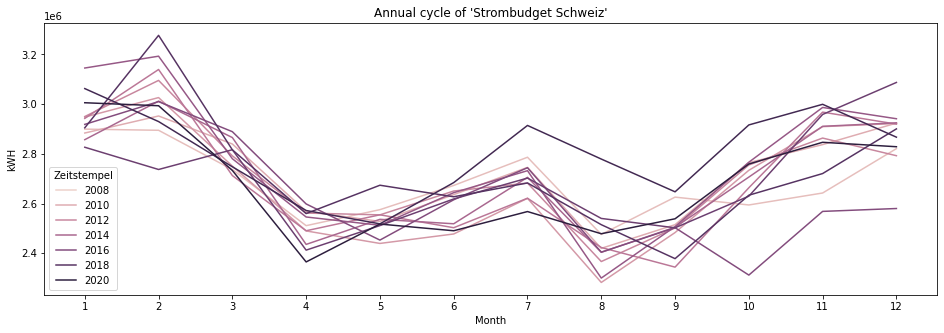

In [55]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(data=data_m, 
             x=data_m.index.month, 
             y="Strombudget Schweiz", 
             hue=data_m.index.year)
ax.set_xticks(range(1,13))
plt.title("Annual cycle of 'Strombudget Schweiz'")
plt.xlabel("Month")
plt.ylabel("kWH")
plt.show()

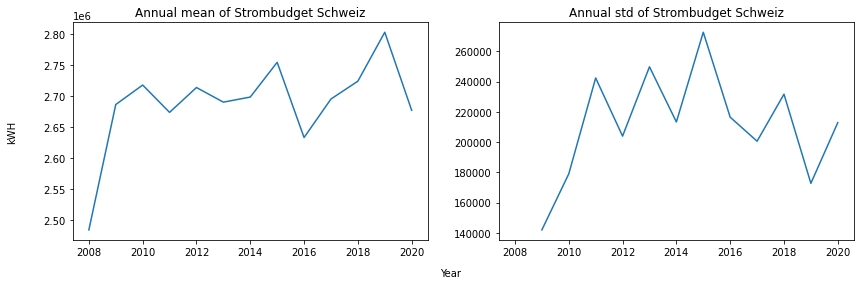

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4), sharex=True)
ax1.plot(data_m.groupby(data_m.index.year).mean()["Strombudget Schweiz"])
ax1.set_title('Annual mean of Strombudget Schweiz')
ax2.plot(data_m.groupby(data_m.index.year).std()["Strombudget Schweiz"])
ax2.set_title('Annual std of Strombudget Schweiz')
fig.text(0.5, 0.00, 'Year', ha='center')
fig.text(0.06, 0.5, 'kWH', va='center', rotation='vertical')
plt.show()

Auch hier ist für uns nicht eindeutig erkennbar, ob ein additives oder multiplikatives Modell längerfristig zur Vorhersage des Strombudgets besser geeignet ist. Die Korrelation zwischen Erwartungswert und Standardabweichung zeigt ein ähnliches Muster wie beim Stromverbrauch.

#### Strombilanz Schweiz

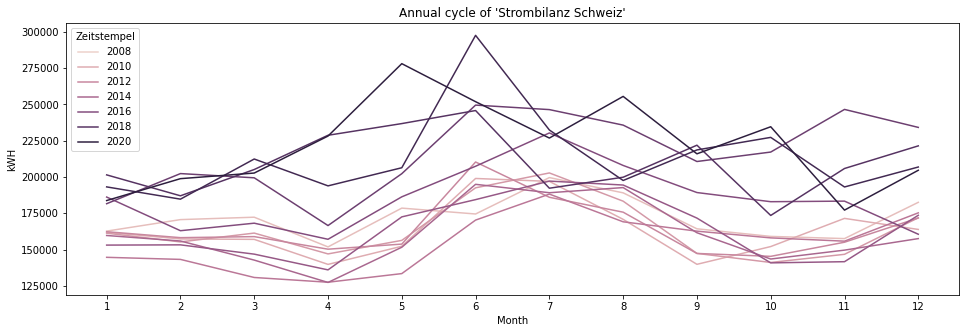

In [57]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(data=data_m, 
             x=data_m.index.month, 
             y="Strombilanz Schweiz", 
             hue=data_m.index.year)
ax.set_xticks(range(1,13))
plt.title("Annual cycle of 'Strombilanz Schweiz'")
plt.xlabel("Month")
plt.ylabel("kWH")
plt.show()

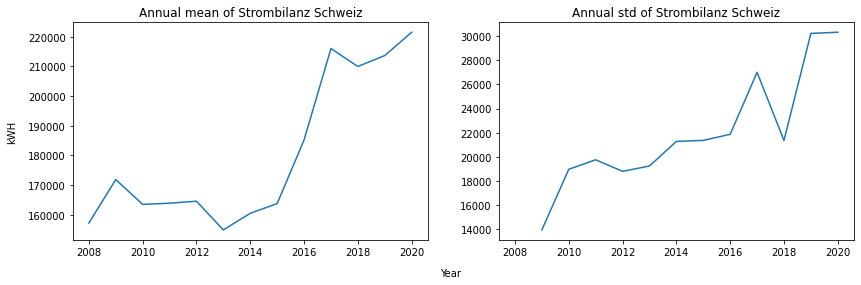

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4), sharex=True)
ax1.plot(data_m.groupby(data_m.index.year).mean()["Strombilanz Schweiz"])
ax1.set_title('Annual mean of Strombilanz Schweiz')
ax2.plot(data_m.groupby(data_m.index.year).std()["Strombilanz Schweiz"])
ax2.set_title('Annual std of Strombilanz Schweiz')
fig.text(0.5, 0.00, 'Year', ha='center')
fig.text(0.06, 0.5, 'kWH', va='center', rotation='vertical')
plt.show()

Bei der Strombilanz scheint eine Korrelation zwischen Erwartungswert und Standardabweichung vorhanden zu sein. Hier würden wir im Falle einer Vorhersage deshalb vermutlich ein multiplikatives Modell vorziehen.

## Train-Test Split

Um die Qualität unserer Vorhersagen ungefähr einschätzen zu können teilen wir diese in ein Trainings und Testset auf. Das Splitdatum ist der 31. Dez 2017 um 00:00 Uhr. Dadurch haben wir eine Zeitspanne von 9 Jahren im Trainingsset und 3 Jahre im Testset.

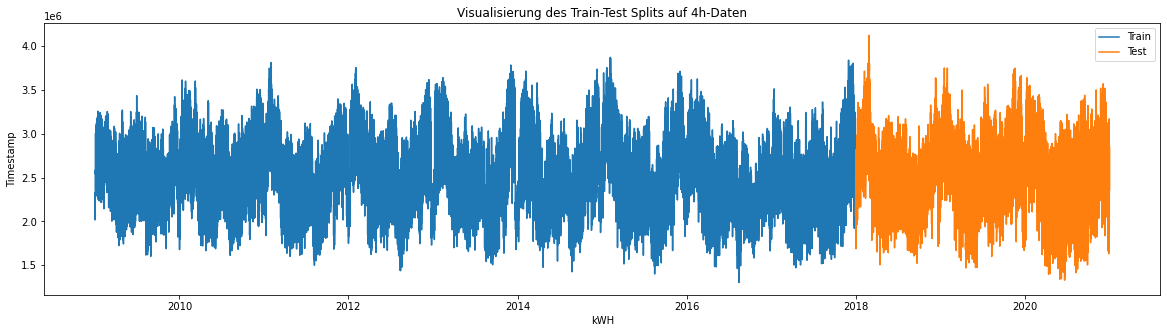

In [59]:
data_4h_train, data_4h_test = data_4h[:'2017-12-31 00:00:00+00:00'], data_4h['2017-12-31 00:00:00+00:00':]
data_d_train, data_d_test = data_d[:'2017-12-31 00:00:00+00:00'], data_d['2017-12-31 00:00:00+00:00':]
data_m_train, data_m_test = data_m[:'2017-12-31 00:00:00+00:00'], data_m['2017-12-31 00:00:00+00:00':]

plt.figure(figsize=(20,5))
plt.plot(data_4h_train["Stromverbrauch Schweiz"], label="Train")
plt.plot(data_4h_test["Stromverbrauch Schweiz"], label="Test")
plt.title("Visualisierung des Train-Test Splits auf 4h-Daten")
plt.xlabel("kWH")
plt.ylabel("Timestamp")
plt.legend()
plt.show()

### Zerlegung der 4-Stunden Daten

Hier zerlegen wir die 4-stündlichen Trainingsdaten. Dafür zerlegen wir die Daten zuerst in Bezug auf den Tageszyklus. Anschliessend wird dieser von der originalen 4-Stunden Zeitreihe herausgefiltert. Diese Prozedur wird anschliessend noch für die wöchentliche und jährliche Saisonalität wiederholt.

Die nachfolgenden Visualisierungen zeigen die Zerlegung unserer 4-stündlichen Zeitreihen in einen Trend, Tägliche-, Wöchentliche-, und Jährliche Saisonalität.

#### Zerlegung des Stromverbrauchs

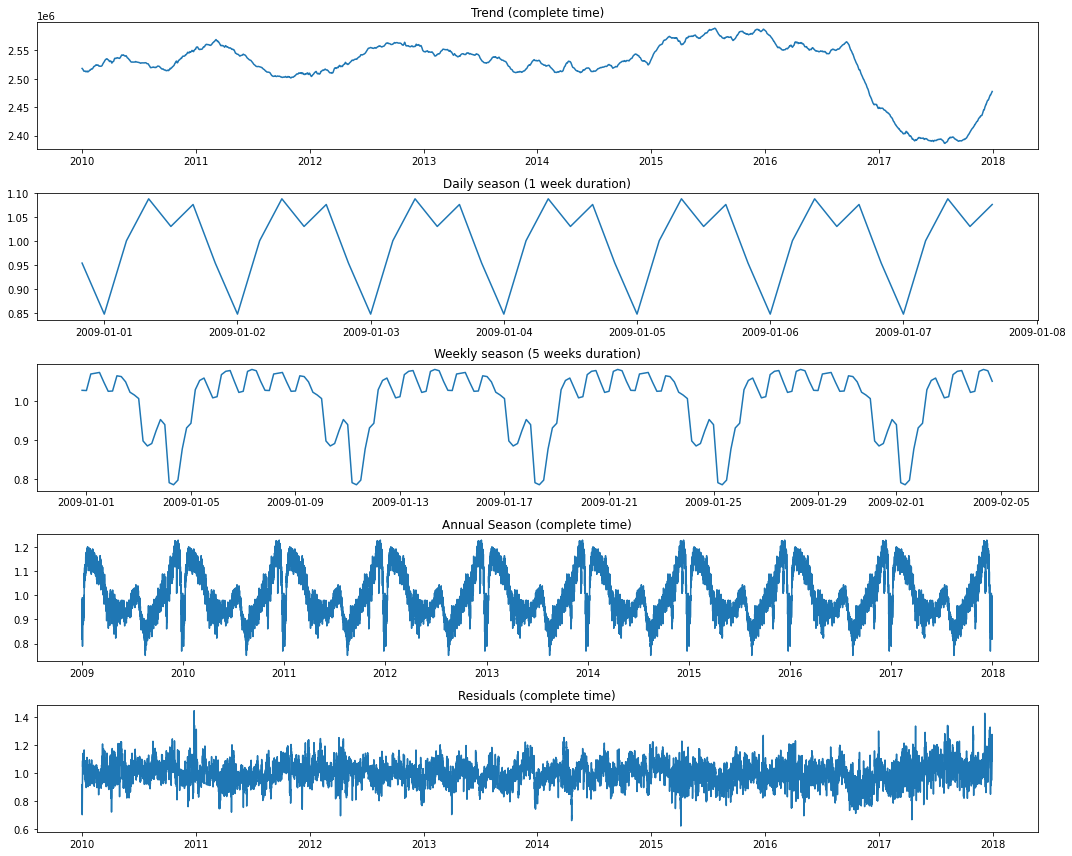

In [60]:
df_v = data_4h_train["Stromverbrauch Schweiz"]

# daily season
d_v = seasonal_decompose(df_v, period=6, model="multiplicative", two_sided=False)
r_v = df_v / d_v.seasonal
# monthly season
w_v = seasonal_decompose(r_v, period=6*7, model="multiplicative", two_sided=False)
r_v = r_v / w_v.seasonal
# annual season
a_v = seasonal_decompose(r_v, period=6*365, model="multiplicative", two_sided=False)
r_v = r_v / a_v.seasonal

fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(5,1, figsize=(15,12))
ax0.plot(a_v.trend)
ax1.plot(d_v.seasonal[0:6*7])
ax2.plot(w_v.seasonal[0:6*7*5])
ax3.plot(a_v.seasonal)
ax4.plot(a_v.resid)

ax0.title.set_text('Trend (complete time)')
ax1.title.set_text('Daily season (1 week duration)')
ax2.title.set_text('Weekly season (5 weeks duration)')
ax3.title.set_text('Annual Season (complete time)')
ax4.title.set_text('Residuals (complete time)')
fig.tight_layout()
plt.show()

#### Zerlegung des Strombudgets

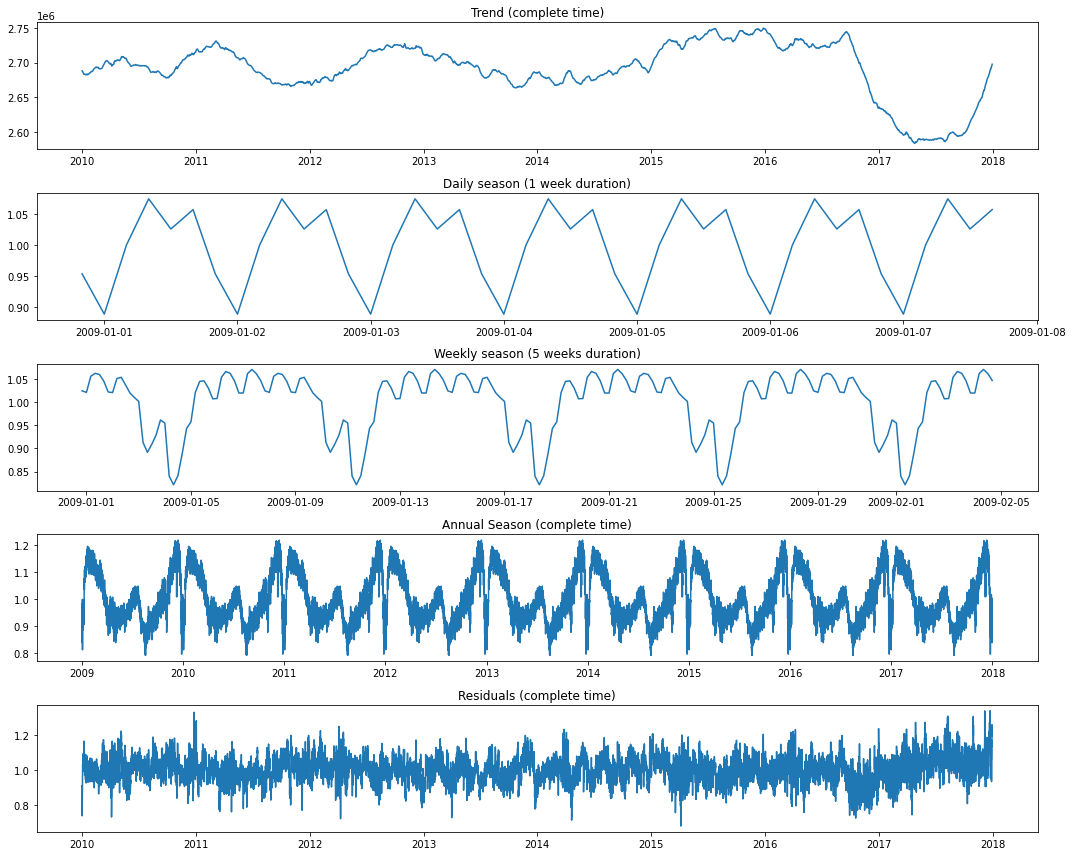

In [61]:
df_p = data_4h_train["Strombudget Schweiz"]

# daily season
d_p = seasonal_decompose(df_p, period=6, model="multiplicative", two_sided=False)
r_p = df_p / d_p.seasonal
# monthly season
w_p = seasonal_decompose(r_p, period=6*7, model="multiplicative", two_sided=False)
r_p = r_p / w_p.seasonal
# annual season
a_p = seasonal_decompose(r_p, period=6*365, model="multiplicative", two_sided=False)
r_p = r_p / a_p.seasonal

fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(5,1, figsize=(15,12))
ax0.plot(a_p.trend)
ax1.plot(d_p.seasonal[0:6*7])
ax2.plot(w_p.seasonal[0:6*7*5])
ax3.plot(a_p.seasonal)
ax4.plot(a_p.resid)

ax0.title.set_text('Trend (complete time)')
ax1.title.set_text('Daily season (1 week duration)')
ax2.title.set_text('Weekly season (5 weeks duration)')
ax3.title.set_text('Annual Season (complete time)')
ax4.title.set_text('Residuals (complete time)')
fig.tight_layout()
plt.show()

#### Zerlegung des Strombudgets

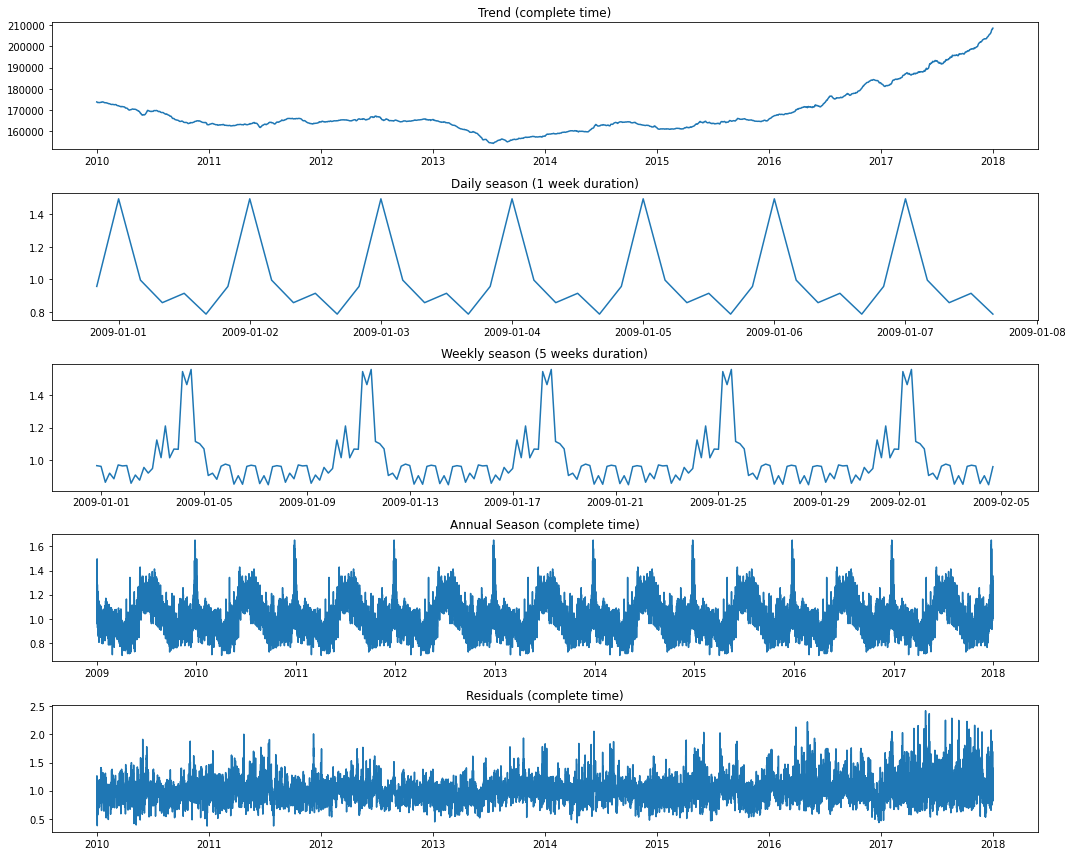

In [62]:
df_b = data_4h_train["Strombilanz Schweiz"]

# daily season
d_b = seasonal_decompose(df_b, period=6, model="multiplicative", two_sided=False)
r_b = df_b / d_b.seasonal
# monthly season
w_b = seasonal_decompose(r_b, period=6*7, model="multiplicative", two_sided=False)
r_b = r_b / w_b.seasonal
# annual season
a_b = seasonal_decompose(r_b, period=6*365, model="multiplicative", two_sided=False)
r_b = r_b / a_b.seasonal

fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(5,1, figsize=(15,12))
ax0.plot(a_b.trend)
ax1.plot(d_b.seasonal[0:6*7])
ax2.plot(w_b.seasonal[0:6*7*5])
ax3.plot(a_b.seasonal)
ax4.plot(a_b.resid)

ax0.title.set_text('Trend (complete time)')
ax1.title.set_text('Daily season (1 week duration)')
ax2.title.set_text('Weekly season (5 weeks duration)')
ax3.title.set_text('Annual Season (complete time)')
ax4.title.set_text('Residuals (complete time)')
fig.tight_layout()
plt.show()

### Terndschätzung mittels linearer Regression.

Durch die saisonale Zerlegung haben wir den Trend als "Rolling mean" zurückerhalten. Unter der Annahme, dass dieser Trend über einen längeren Zeitraum linear ist und sich im bestehenden Muster weiterentwickelt, wollen wir nun für die Vorhersage des Trends mittels einer linearen Regression vornehmen. Da das Jahr 2017 ein Jahr war, an dem der Trend des Stromverbrauchs und des Strombudgets deutlich unter dem Erwartungswert der letzten Jahre lag und wir vermuten, es sich hier nicht um eine nachhaltige Entwicklung handelt, lassen wir dieses bei der Trendbildung weg.

#### Trendschätzung Stromverbrauch

In [63]:
start_date = '2008-12-31 20:00:00+00:00'
end_date = '2016-06-30 00:00:00+00:00'


mask = (a_v.trend.index > start_date) & (a_v.trend.index <= end_date)
trend = df_v.loc[mask].dropna()

X = np.arange(len(trend.dropna())).reshape(-1,1)
y = trend.dropna().values
reg = LinearRegression().fit(X, y)
trend_pred_v = reg.predict(np.arange(len(a_v.trend)).reshape(-1,1))

print("Intercept:", reg.intercept_)
print("Slope:", reg.coef_[0])

Intercept: 2522831.722586555
Slope: 2.283844707624236


#### Trendschätzung Strombudget

In [64]:
start_date = '2008-12-31 20:00:00+00:00'
end_date = '2016-06-30 00:00:00+00:00'
mask = (a_p.trend.index > start_date) & (a_p.trend.index <= end_date)
trend = df_p.loc[mask].dropna()

X = np.arange(len(trend.dropna())).reshape(-1,1)
y = trend.dropna().values
reg = LinearRegression().fit(X, y)
trend_pred_p = reg.predict(np.arange(len(a_p.trend)).reshape(-1,1))

print("Intercept:", reg.intercept_)
print("Slope:", reg.coef_[0])

Intercept: 2687939.5030190037
Slope: 2.1931392069334437


#### Trendschätzung Strombilanz

In [65]:
start_date = '2008-12-31 20:00:00+00:00'
end_date = '2020-06-30 00:00:00+00:00'
mask = (a_b.trend.index > start_date) & (a_b.trend.index <= end_date)
trend = df_b.loc[mask].dropna()

X = np.arange(len(trend.dropna())).reshape(-1,1)
y = trend.dropna().values
reg = LinearRegression().fit(X, y)
trend_pred_b = reg.predict(np.arange(len(a_b.trend)).reshape(-1,1))

print("Intercept:", reg.intercept_)
print("Slope:", reg.coef_[0])

Intercept: 153340.50169456255
Slope: 1.8542742945151298


### Rekonstruktion der Zeitreihe

Nun rekonstruieren wir die Zeitreihe für den Stromverbrauch und das Strombudget auf dem Testset mittels linearen Trend und unseren Saisonalitäten.

In [66]:
reconstructed_v = trend_pred_v  * d_v.seasonal * a_v.seasonal * w_v.seasonal
reconstructed_p = trend_pred_p  * d_p.seasonal * a_p.seasonal * w_p.seasonal
reconstructed_b = trend_pred_b  * d_b.seasonal * a_b.seasonal * w_b.seasonal

data_4h_diff = data_4h["Stromverbrauch Schweiz"] - reconstructed_v
data_4h_diff = data_4h["Strombudget Schweiz"] - reconstructed_p

#### Stromverbrauch

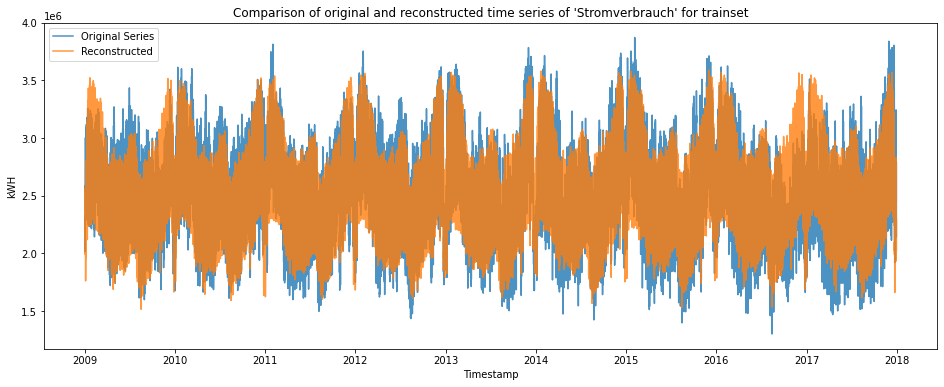

Mean avg percentage error: 0.06436046557042172
Mean absolute error: 156213.02040300908


In [67]:
plt.figure(figsize=(16,6))
plt.plot(data_4h_train["Stromverbrauch Schweiz"], alpha=0.8, label="Original Series")
plt.plot(reconstructed_v, alpha=0.8, label="Reconstructed")
plt.legend()
plt.title("Comparison of original and reconstructed time series of 'Stromverbrauch' for trainset")
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(data_4h_train["Stromverbrauch Schweiz"], reconstructed_v))
print("Mean absolute error:", mean_absolute_error(data_4h_train["Stromverbrauch Schweiz"], reconstructed_v))

#### Strombudget

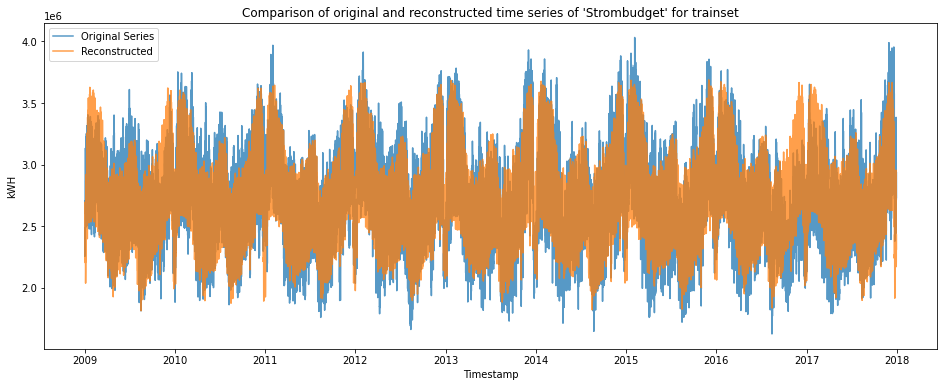

Mean avg percentage error: 0.05719868351819821
Mean absolute error: 150049.97222682872


In [68]:
plt.figure(figsize=(16,6))
plt.plot(data_4h_train["Strombudget Schweiz"], alpha=0.75, label="Original Series")
plt.plot(reconstructed_p, alpha=0.75, label="Reconstructed")
plt.legend()
plt.title("Comparison of original and reconstructed time series of 'Strombudget' for trainset")
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(data_4h_train["Strombudget Schweiz"], reconstructed_p))
print("Mean absolute error:", mean_absolute_error(data_4h_train["Strombudget Schweiz"], reconstructed_p))

#### Strombilanz

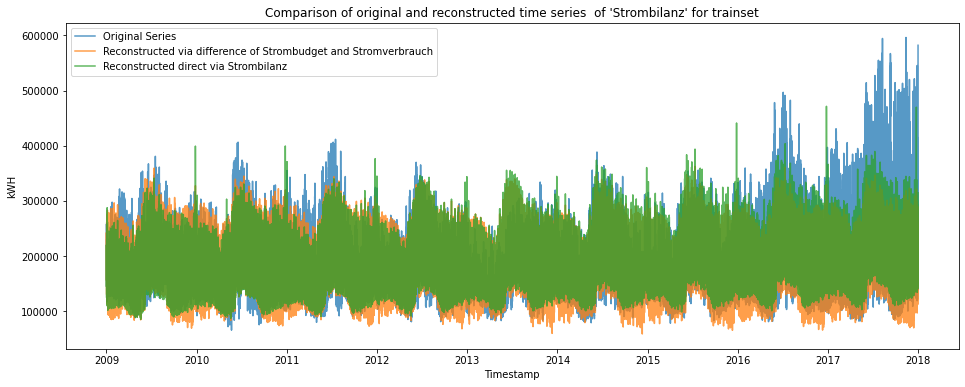


Comparison of Original & Reconstructed from 'Strombilanz'
Mean avg percentage error: 0.16780914338743655
Mean absolute error: 29286.298016589135

Comparison of Original & Reconstructed from 'Strombudget' - 'Stromverbrauch'
Mean avg percentage error: 0.18520491299731606
Mean absolute error: 32566.595533339158

Comparison of Reconstructed from 'Strombilanz' & Reconstructed from 'Strombudget' - 'Stromverbrauch'
Mean avg percentage error: 0.08548526189703881
Mean absolute error: 13926.056397703887


In [69]:
plt.figure(figsize=(16,6))
plt.plot(data_4h_train["Strombilanz Schweiz"], alpha=0.75, label="Original Series")
plt.plot(reconstructed_p-reconstructed_v, alpha=0.75, label="Reconstructed via difference of Strombudget and Stromverbrauch")
plt.plot(reconstructed_b, alpha=0.75, label="Reconstructed direct via Strombilanz")

plt.legend()
plt.title("Comparison of original and reconstructed time series  of 'Strombilanz' for trainset")
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.show()


print("\nComparison of Original & Reconstructed from 'Strombilanz'")
print("Mean avg percentage error:", mean_absolute_percentage_error(data_4h_train["Strombilanz Schweiz"], reconstructed_b))
print("Mean absolute error:", mean_absolute_error(data_4h_train["Strombilanz Schweiz"], reconstructed_b))

print("\nComparison of Original & Reconstructed from 'Strombudget' - 'Stromverbrauch'")
print("Mean avg percentage error:", mean_absolute_percentage_error(data_4h_train["Strombilanz Schweiz"], reconstructed_p-reconstructed_v))
print("Mean absolute error:", mean_absolute_error(data_4h_train["Strombilanz Schweiz"], reconstructed_p-reconstructed_v))

print("\nComparison of Reconstructed from 'Strombilanz' & Reconstructed from 'Strombudget' - 'Stromverbrauch'")
print("Mean avg percentage error:", mean_absolute_percentage_error(reconstructed_b, reconstructed_p-reconstructed_v))
print("Mean absolute error:", mean_absolute_error(reconstructed_b, reconstructed_p-reconstructed_v))

**ToDo:** Beide rekonstruierten Zeitreihen zeigen ab 2017 eine wachsende Differenz zur tatsächlichen Zeitreihe. Hier sollte eventuell versucht werden eine bessere Modellierung des Trends vorzunehmen. Aus zeitlichen Gründen war das aktuell nicht mehr drin.

#### Testset

In [70]:
def predict_future(df, days):
    '''extends the timeseries n days into the future'''
    base = df.index[0]

    for _ in range(6 * days):
        df=df.append({"trend_pred":df.iloc[-1][0] - (df.iloc[-2][0] - df.iloc[-1][0]),"annual_season":df.iloc[-365*6][1],
                         "weekly_season":df.iloc[-7*6][2],"daily_season":df.iloc[-6][3]}, ignore_index=True)   
    index_list=[]
    for x in range(len(df)):
        index_list.append(base)
        base += datetime.timedelta(hours=4)
    df["reconstructed"] = df["trend_pred"] * df["annual_season"] * df["weekly_season"] * df["daily_season"]

    # Set index to timesamp
    df["timestamp"] = index_list
    df = df.set_index("timestamp")
    return df



predict_n_days = 365 * 20 # 20 Years

df_re_v = pd.DataFrame({"trend_pred":trend_pred_v, "annual_season":a_v.seasonal, 
                          "weekly_season":w_v.seasonal,"daily_season":d_v.seasonal,})
df_re_v = predict_future(df_re_v, predict_n_days)

df_re_p = pd.DataFrame({"trend_pred":trend_pred_p, "annual_season":a_p.seasonal, 
                          "weekly_season":w_p.seasonal, "daily_season":d_p.seasonal,})
df_re_p = predict_future(df_re_p, predict_n_days)

df_re_b = pd.DataFrame({"trend_pred":trend_pred_b, "annual_season":a_b.seasonal, 
                          "weekly_season":w_b.seasonal, "daily_season":d_b.seasonal,})
df_re_b = predict_future(df_re_b, predict_n_days)

#### Nächster Monat

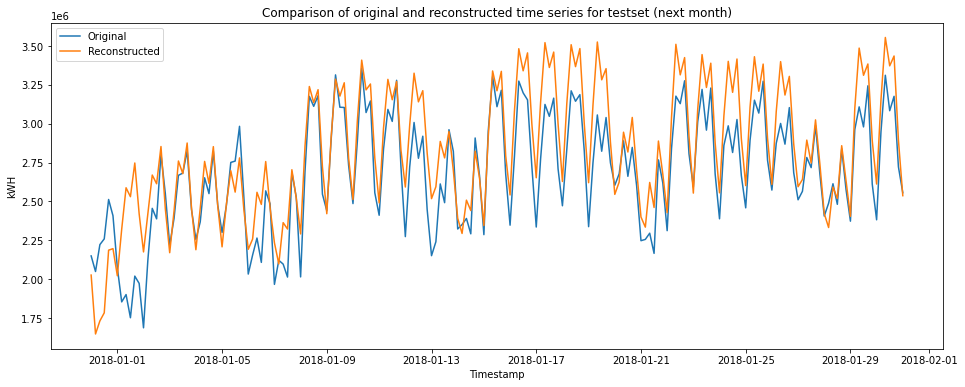

Mean avg percentage error: 0.06692433951255283
Mean absolute error: 185829.30877942053


In [71]:
plt.figure(figsize=(16,6))
next_m_pred = df_re_v["reconstructed"]['2017-12-31 00:00:00+00:00':'2018-01-31 00:00:00+00:00']
next_m_is = data_4h_test["Stromverbrauch Schweiz"]['2017-12-31 00:00:00+00:00':'2018-01-31 00:00:00+00:00']
plt.plot(next_m_is, label="Original")
plt.plot(next_m_pred, label="Reconstructed")
plt.title("Comparison of original and reconstructed time series for testset (next month)")
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(next_m_pred, next_m_is))
print("Mean absolute error:", mean_absolute_error(next_m_pred, next_m_is))

In der Visualisierung sehen wir die tatsächliche Zeitreihe und die rekonstruierte Zeitreihe für den nächsten Monat. Die erweiterte Trainings-Zeitreihe hat einen durchschnittlichen prozentualen Fehler von 6.7 Prozent im Vergleich zur ursprünglichen Zeitreihe

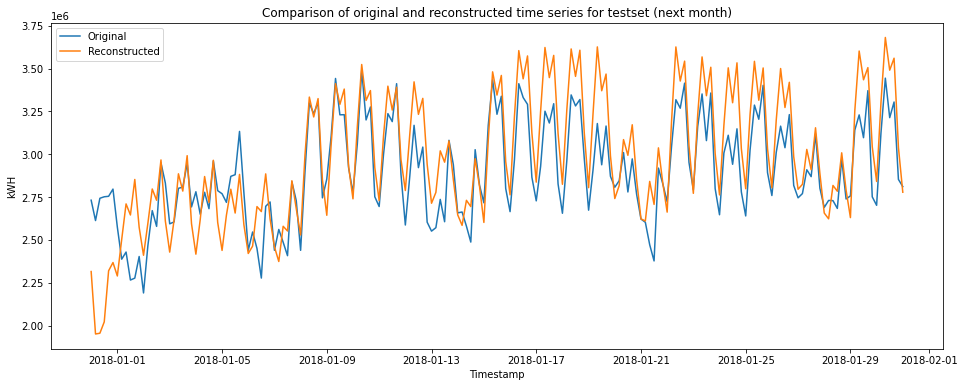

Mean avg percentage error: 0.059625213722668456
Mean absolute error: 172562.63913258535


In [72]:
plt.figure(figsize=(16,6))
next_m_pred = df_re_p["reconstructed"]['2017-12-31 00:00:00+00:00':'2018-01-31 00:00:00+00:00']
next_m_is = data_4h_test["Strombudget Schweiz"]['2017-12-31 00:00:00+00:00':'2018-01-31 00:00:00+00:00']

plt.plot(next_m_is, label="Original")
plt.plot(next_m_pred, label="Reconstructed")
plt.title("Comparison of original and reconstructed time series for testset (next month)")
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(next_m_pred, next_m_is))
print("Mean absolute error:", mean_absolute_error(next_m_pred, next_m_is))

In der Visualisierung sehen wir die tatsächliche Zeitreihe und die rekonstruierte Zeitreihe für das Strombudget des nächsten Monates. Die rekonstruierte Trainings-Zeitreihe hat einen durchschnittlichen prozentualen Fehler von 5.9 Prozent im Vergleich zur ursprünglichen Zeitreihe.

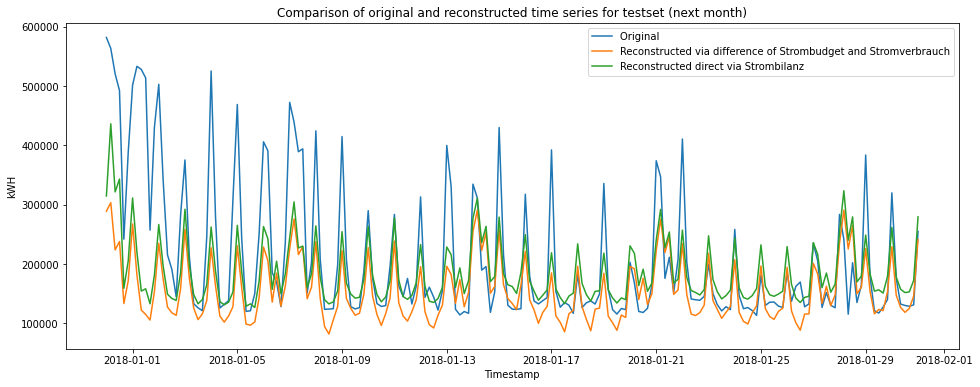

Mean avg percentage error: 0.9237477612691588
Mean absolute error: 2769019.649990147


In [73]:
plt.figure(figsize=(16,6))
next_m_is = data_4h_test["Strombilanz Schweiz"]['2017-12-31 00:00:00+00:00':'2018-01-31 00:00:00+00:00']
next_m_pred_pv = df_re_p["reconstructed"]['2017-12-31 00:00:00+00:00':'2018-01-31 00:00:00+00:00'] - df_re_v["reconstructed"]['2017-12-31 00:00:00+00:00':'2018-01-31 00:00:00+00:00']
next_m_pred_b = df_re_b["reconstructed"]['2017-12-31 00:00:00+00:00':'2018-01-31 00:00:00+00:00']
plt.plot(next_m_is, label="Original ")
plt.plot(next_m_pred_pv, label="Reconstructed via difference of Strombudget and Stromverbrauch")
plt.plot(next_m_pred_b, label="Reconstructed direct via Strombilanz")
plt.title("Comparison of original and reconstructed time series for testset (next month)")
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(next_m_pred, next_m_is))
print("Mean absolute error:", mean_absolute_error(next_m_pred, next_m_is))

#### Komplettes Testset

##### Stromverbrauch

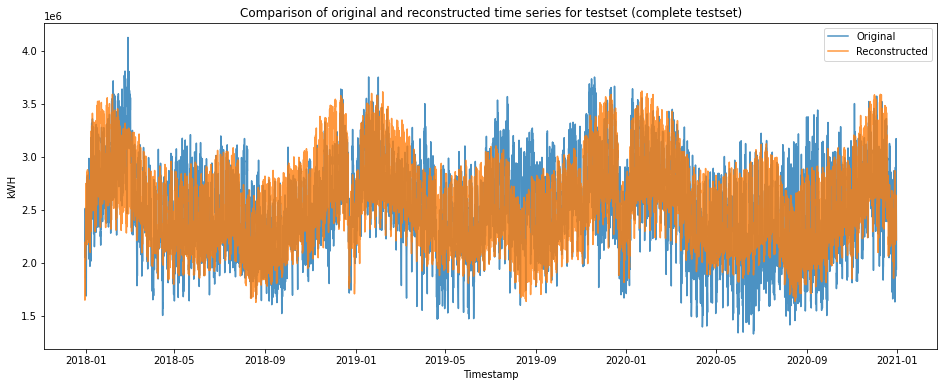

Mean avg percentage error: 0.08187407637272337
Mean absolute error: 207380.55703568013


In [74]:
plt.figure(figsize=(16,6))
next_3y_pred = df_re_v["reconstructed"]['2017-12-31 00:00:00+00:00':'2020-12-31 00:00:00+00:00']
next_3y_is = data_4h_test["Stromverbrauch Schweiz"]['2017-12-31 00:00:00+00:00':'2020-12-31 00:00:00+00:00']
plt.plot(next_3y_is, alpha=0.8, label="Original")
plt.plot(next_3y_pred, alpha=0.8, label="Reconstructed")
plt.title("Comparison of original and reconstructed time series for testset (complete testset)")
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(next_3y_pred, next_3y_is))
print("Mean absolute error:", mean_absolute_error(next_3y_pred, next_3y_is))

In der Visualisierung sehen wir die tatsächliche Zeitreihe und die rekonstruierte Zeitreihe für den Stromverbrauch des komplette Testset, was einer Dauer von 3 Jahren entspricht. Die rekonstruierte Trainings-Zeitreihe hat einen durchschnittlichen prozentualen Fehler von 8.1 Prozent im Vergleich zur ursprünglichen Zeitreihe.

##### Strombudget

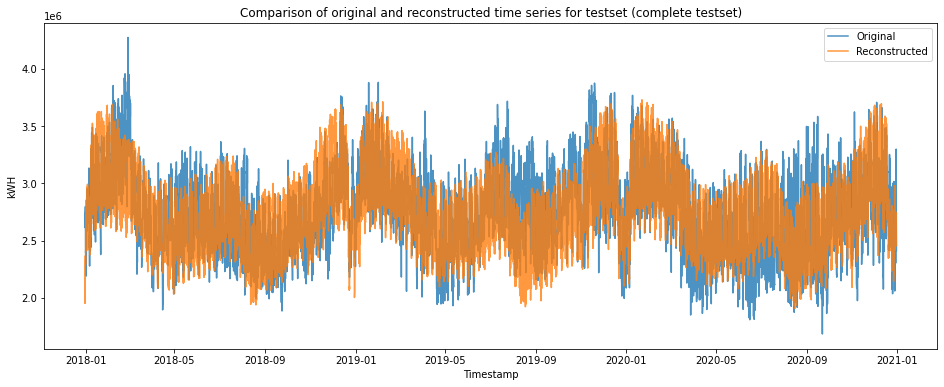

Mean avg percentage error: 0.07065253824206034
Mean absolute error: 191576.97732640972


In [75]:
plt.figure(figsize=(16,6))
next_3y_pred = df_re_p["reconstructed"]['2017-12-31 00:00:00+00:00':'2020-12-31 00:00:00+00:00']
next_3y_is = data_4h_test["Strombudget Schweiz"]['2017-12-31 00:00:00+00:00':'2020-12-31 00:00:00+00:00']
plt.plot(next_3y_is, alpha=0.8, label="Original")
plt.plot(next_3y_pred, alpha=0.8, label="Reconstructed")
plt.title("Comparison of original and reconstructed time series for testset (complete testset)")
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(next_3y_pred, next_3y_is))
print("Mean absolute error:", mean_absolute_error(next_3y_pred, next_3y_is))

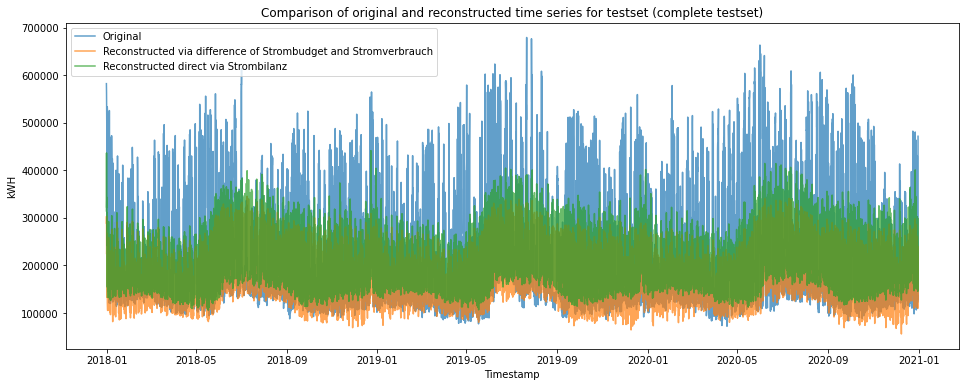


Comparison of Original & Reconstructed from 'Strombilanz'
Mean avg percentage error: 0.2641099054021016
Mean absolute error: 70463.1231396148

Comparison of Original & Reconstructed from 'Strombudget' - 'Stromverbrauch'
Mean avg percentage error: 0.29451837485931437
Mean absolute error: 66690.25494984491

Comparison of Reconstructed from 'Strombilanz' & Reconstructed from 'Strombudget' - 'Stromverbrauch'
Mean avg percentage error: 0.1743381106326014
Mean absolute error: 32460.753650296498


In [76]:
plt.figure(figsize=(16,6))
next_3y_pred_pv = df_re_p["reconstructed"]['2017-12-31 00:00:00+00:00':'2020-12-31 00:00:00+00:00'] - df_re_v["reconstructed"]['2017-12-31 00:00:00+00:00':'2020-12-31 00:00:00+00:00']
next_3y_pred_b = df_re_b["reconstructed"]['2017-12-31 00:00:00+00:00':'2020-12-31 00:00:00+00:00']
next_3y_is = data_4h_test["Strombilanz Schweiz"]['2017-12-31 00:00:00+00:00':'2020-12-31 00:00:00+00:00']
plt.plot(next_3y_is, alpha=0.7, label="Original")
plt.plot(next_3y_pred_pv, alpha=0.7, label="Reconstructed via difference of Strombudget and Stromverbrauch")
plt.plot(next_3y_pred_b, alpha=0.7, label="Reconstructed direct via Strombilanz")
plt.title("Comparison of original and reconstructed time series for testset (complete testset)")
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.legend()
plt.show()


print("\nComparison of Original & Reconstructed from 'Strombilanz'")
print("Mean avg percentage error:", mean_absolute_percentage_error(next_3y_is, next_3y_pred_pv))
print("Mean absolute error:", mean_absolute_error(next_3y_is, next_3y_pred_pv))

print("\nComparison of Original & Reconstructed from 'Strombudget' - 'Stromverbrauch'")
print("Mean avg percentage error:", mean_absolute_percentage_error(next_3y_is, next_3y_pred_b))
print("Mean absolute error:", mean_absolute_error(next_3y_is, next_3y_pred_b))

print("\nComparison of Reconstructed from 'Strombilanz' & Reconstructed from 'Strombudget' - 'Stromverbrauch'")
print("Mean avg percentage error:", mean_absolute_percentage_error(next_3y_pred_b, next_3y_pred_pv))
print("Mean absolute error:", mean_absolute_error(next_3y_pred_b, next_3y_pred_pv))

#### Nächste 20 Jahre konstruieren

##### Strombudget - Stromverbrauch

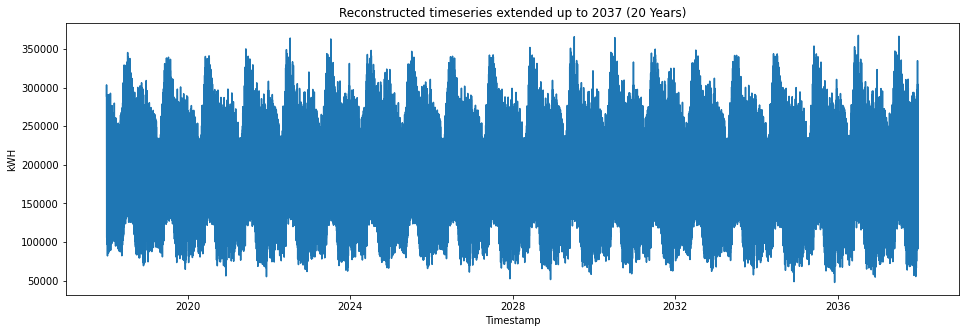

In [41]:
balance_20y = df_re_p["reconstructed"] - df_re_v["reconstructed"]

plt.figure(figsize=(16,5))
plt.title("Reconstructed timeseries extended up to 2037 (20 Years)")
plt.plot(balance_20y['2017-12-31 00:00:00+00:00':'2037-12-31 00:00:00+00:00'])
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.show()

##### Strombilanz

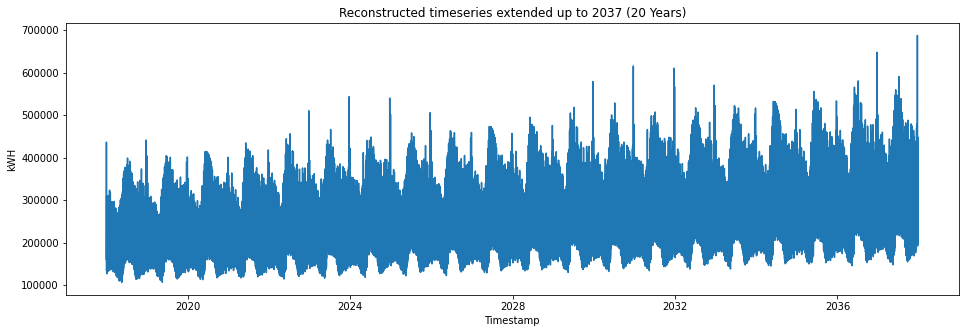

In [42]:
balance_20y = df_re_b["reconstructed"] 

plt.figure(figsize=(16,5))
plt.title("Reconstructed timeseries extended up to 2037 (20 Years)")
plt.plot(balance_20y['2017-12-31 00:00:00+00:00':'2037-12-31 00:00:00+00:00'])
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.show()

## Arima Model

### Monthly data

In diesem Abschnitt erstellen wir ein einfaches Arima-Model auf den monatlichen Daten. Dafür untersuchen wir nochmals die Lags der monatlichen Trainingsdaten auf ihre Autokorrelation resp. partielle Autokorrelation.

#### ACF & PACF Stromverbrauch Schweiz

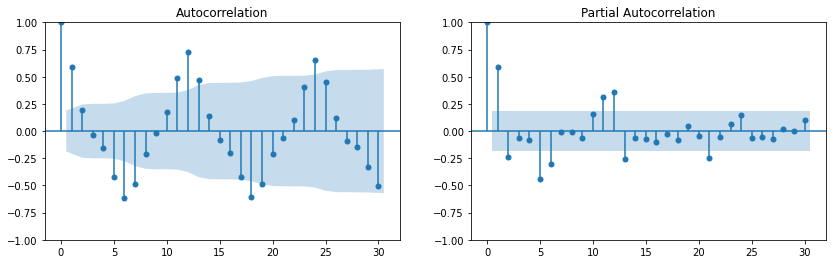

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4), sharex=True)
plot_acf(data_m_train["Stromverbrauch Schweiz"], lags=30, ax=ax1)
plot_pacf(data_m_train["Stromverbrauch Schweiz"], lags=30, method='ywm', ax=ax2)

plt.show()

Der Autokorrelationsplot zeigt einen signifikanten Lag. Deshalb wählen wir $q = 1$. Wir verzichten ausserdem auf eine Integration und wählen $d = 0$. Wir sehen zudem signifikante Lags alle 12 Monate.

Der partielle Autokorrelationsplot zeigt zwei signifikante Lags. Deshalb wählen wir $p = 2$. Da ACF und PACF im 12-Monats-Zyklus ebenfalls signifikante Lags zeigen, wählen wir zusätzlich eine saisonale Komponente im ARIMA Modell mit $s=12$.

#### ACF & PACF Strombudget Schweiz

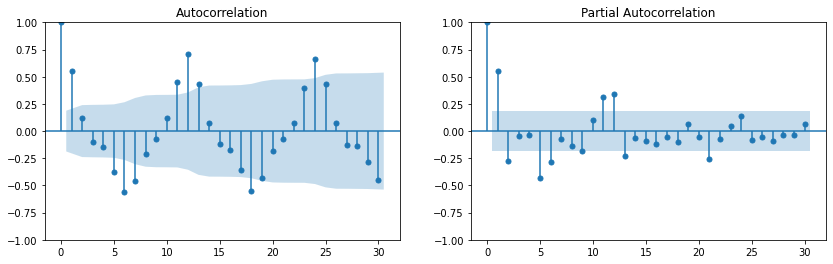

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4), sharex=True)
plot_acf(data_m_train["Strombudget Schweiz"], lags=30, ax=ax1)

plot_pacf(data_m_train["Strombudget Schweiz"], lags=30, method='ywm', ax=ax2)

plt.show()

Der ACF und PACF für das Strombudget sehr ähnlich aus wie der Stromverbrauch. Wir wählen auch hier $q = 1$, $d = 0$ und $p = 2$, als auch eine saisonale 12 monatige Komponente $s=12$.

#### ACF & PACF Strombilanz Schweiz

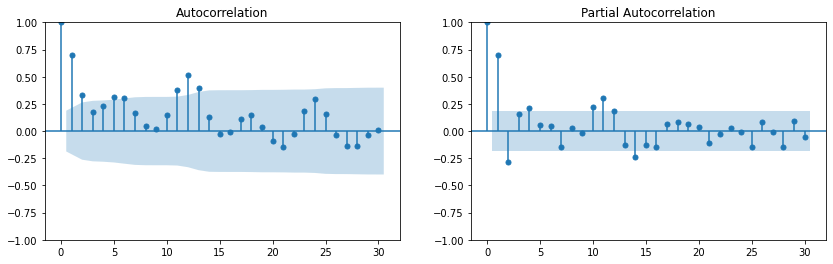

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4), sharex=True)
plot_acf(data_m_train["Strombilanz Schweiz"], lags=30, ax=ax1)

plot_pacf(data_m_train["Strombilanz Schweiz"], lags=30, method='ywm', ax=ax2)

plt.show()

Bei der Strombilanz sehen wir je 2 signifikante Lags beim ACF und PACF Plot. Deshalb wählen wir $q = 2$, $d = 0$ und $p = 2$ und eine saisonale 12 monatige Komponente $s=12$.

#### Training

In [46]:
arima_m_consumption = ARIMA(data_m_train["Stromverbrauch Schweiz"], order=(2, 0, 1), seasonal_order=(2,1,1,12)).fit()

In [47]:
arima_m_generation = ARIMA(data_m_train["Strombudget Schweiz"], order=(2, 0, 1), seasonal_order=(2,1,1,12)).fit()

In [48]:
arima_m_balance = ARIMA(data_m_train["Strombilanz Schweiz"], order=(2, 0, 2), seasonal_order=(2,1,2,12)).fit()

#### Visualize fit on "Stromverbrauch Schweiz"

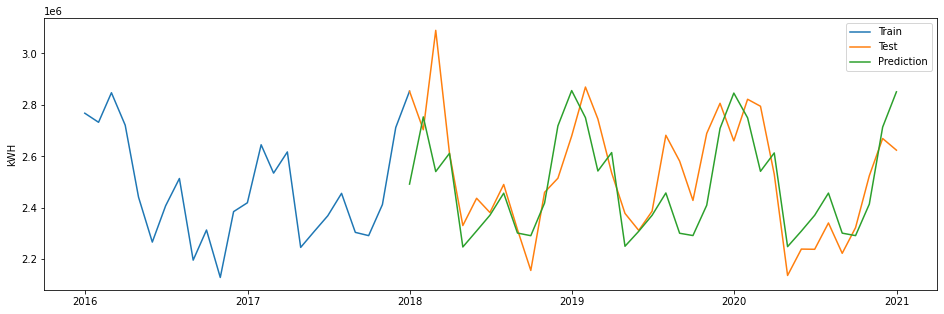

Mean avg percentage error: 0.05260841591788294
Mean absolute error: 131541.2997436123


In [49]:
pred_consumption = arima_m_consumption.predict('2017-12-31 00:00:00+00:00','2020-12-31 00:00:00+00:00')

plt.figure(figsize=(16,5))
plt.plot(data_m_train["Stromverbrauch Schweiz"]['2015-12-31 00:00:00+00:00':], label="Train")
plt.plot(data_m_test["Stromverbrauch Schweiz"], label="Test")
plt.plot(pred_consumption, label="Prediction")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(pred_consumption, data_m_test["Stromverbrauch Schweiz"]))
print("Mean absolute error:", mean_absolute_error(pred_consumption, data_m_test["Stromverbrauch Schweiz"]))

In der Visualisierung sehen wir die Trainings- und Testdaten als auch die Vorhersage mit unserem ARMA Model für den Stromverbrauch. Die Vorhersage hat zum Trainingsset eine mittlere Abweichung von 5.3 Prozentpunkten.

#### Visualize fit on "Strombudget Schweiz"

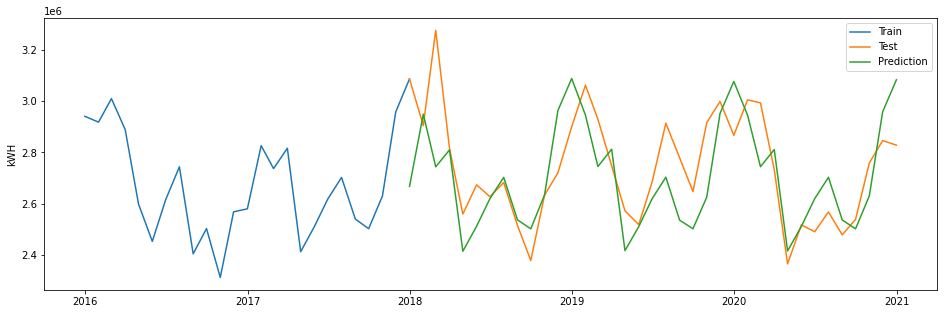

Mean avg percentage error: 0.04929061769388815
Mean absolute error: 134019.6398490188


In [50]:
pred_generation = arima_m_generation.predict('2017-12-31 00:00:00+00:00','2020-12-31 00:00:00+00:00')

plt.figure(figsize=(16,5))
plt.plot(data_m_train["Strombudget Schweiz"]['2015-12-31 00:00:00+00:00':], label="Train")
plt.plot(data_m_test["Strombudget Schweiz"], label="Test")
plt.plot(pred_generation, label="Prediction")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(pred_generation, data_m_test["Strombudget Schweiz"]))
print("Mean absolute error:", mean_absolute_error(pred_generation, data_m_test["Strombudget Schweiz"]))

In der Visualisierung sehen wir die Trainings- und Testdaten als auch die Vorhersage mit unserem ARMA Model für das Strombudget. Die Vorhersage hat zum Trainingsset eine mittlere Abweichung von 4.9 Prozentpunkten.

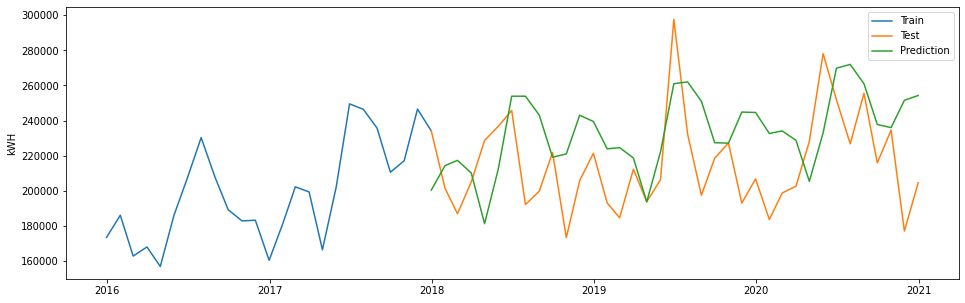

Mean avg percentage error: 0.12390367251548076
Mean absolute error: 29117.24654439679


In [51]:
pred_balance = arima_m_balance.predict('2017-12-31 00:00:00+00:00','2020-12-31 00:00:00+00:00')

plt.figure(figsize=(16,5))
plt.plot(data_m_train["Strombilanz Schweiz"]['2015-12-31 00:00:00+00:00':], label="Train")
plt.plot(data_m_test["Strombilanz Schweiz"], label="Test")
plt.plot(pred_balance, label="Prediction")
plt.ylabel("kWH")
plt.legend()
plt.show()

print("Mean avg percentage error:", mean_absolute_percentage_error(pred_balance, data_m_test["Strombilanz Schweiz"]))
print("Mean absolute error:", mean_absolute_error(pred_balance, data_m_test["Strombilanz Schweiz"]))

#### Voraussage nächste 20 Jahre

Bei der Vorhersage der längerfristigen Strombilanz mittels einem Saisonalen ARIMA Models wählen wir zwei Ansätze. 

1. Ansatz: Wir erstellen unser Model direkt auf der Strombilanz.

2. Wir erstellen zwei separate Modelle auf dem Stromverbrauch und dem Strombudget und nehmen die Differenz dieser beiden Modelle.

In [52]:
from statsmodels.tsa.api import SARIMAX, AutoReg

# training mit der kompletten Zeitreihe
arima_m_consumption = ARIMA(data_m["Stromverbrauch Schweiz"], order=(2, 0, 1), seasonal_order=(2,1,1,12)).fit()
arima_m_generation = ARIMA(data_m["Strombudget Schweiz"], order=(2, 0, 1), seasonal_order=(2,1,1,12)).fit()
arima_m_balance = ARIMA(data_m["Strombilanz Schweiz"], order=(2, 0, 2), seasonal_order=(2,1,1,12)).fit()

Die nachfolgende Visualisierung zeigt die Voraussage des bisherigen monatlichen Stromverbrauchs und dessen Voraussage für die nächsten 20 Jahre.

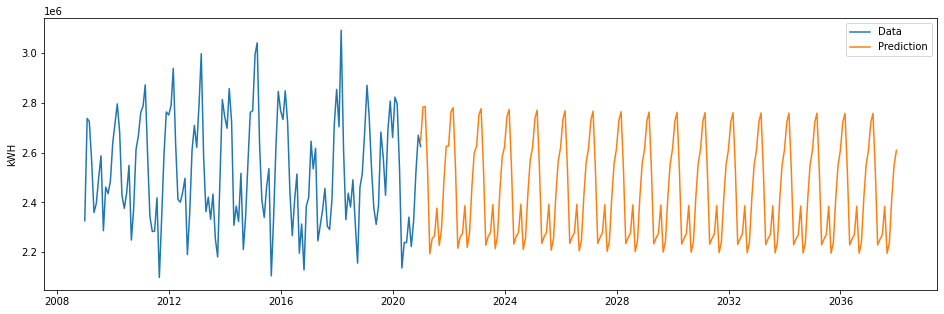

In [53]:
pred_consumption = arima_m_consumption.predict('2020-12-31 00:00:00+00:00','2037-12-31 00:00:00+00:00')
plt.figure(figsize=(16,5))
plt.plot(data_m["Stromverbrauch Schweiz"], label="Data")
plt.plot(pred_consumption, label="Prediction")
plt.ylabel("kWH")
plt.legend()
plt.show()

Die nachfolgende Visualisierung zeigt die Voraussage des bisherigen monatlichen Strombudgets und dessen Voraussage für die nächsten 20 Jahre.

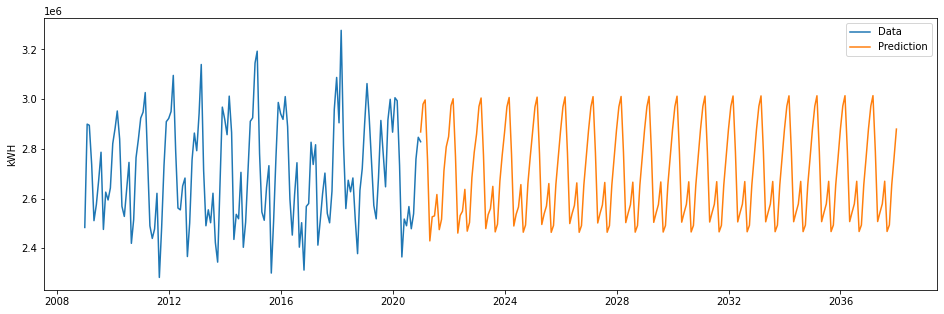

In [54]:
pred_generation = arima_m_generation.predict('2020-12-31 00:00:00+00:00','2037-12-31 00:00:00+00:00')
plt.figure(figsize=(16,5))
plt.plot(data_m["Strombudget Schweiz"], label="Data")
plt.plot(pred_generation, label="Prediction")
plt.ylabel("kWH")
plt.legend()
plt.show()

Die nachfolgende Visualisierung zeigt die Voraussage des bisherigen monatlichen Stromverbrauchs und zwei Voraussagen für die nächsten 20 Jahre. Hier generieren wir die Vorhersage einmal direkt über die Strombilanz und das andere Mal über die Differenz der Vorhersagen von Stromverbrauch und Strombudget.

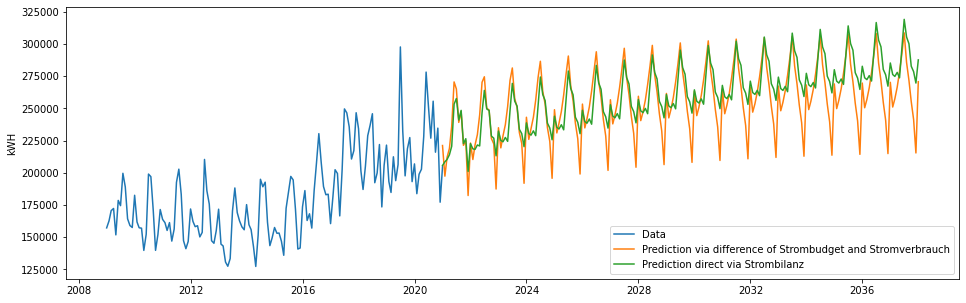

In [55]:
pred_balance = arima_m_balance.predict('2020-12-31 00:00:00+00:00','2037-12-31 00:00:00+00:00')
plt.figure(figsize=(16,5))
plt.plot(data_m["Strombilanz Schweiz"], label="Data")
plt.plot(pred_generation-pred_consumption, label="Prediction via difference of Strombudget and Stromverbrauch")
plt.plot(pred_balance, label="Prediction direct via Strombilanz")
plt.ylabel("kWH")
plt.legend()
plt.show()

Beim Vergleich der beiden Vorhersagen fällt eine grosse periodisch wiederkehrende Differenz jährlich im Januar auf. 

#### Plot reconstructed Timeseries vs Arima prediction

Wir wollen nun überprüfen, wie ähnlich die rekonstruierte Zeitreihe und die Vorhersage unseres ARIMA Models sind. Dafür transformieren wir unsere 4-stündlich rekonstruierte Zeitreihe in monatliche Durchschnittswerte um.

Die nachfolgende Visualisierung zeigt diese monatlichen rekonstruierten Daten und stellt sie der Vorhersage unseres monatlichen ARIMA Models gegenüber.

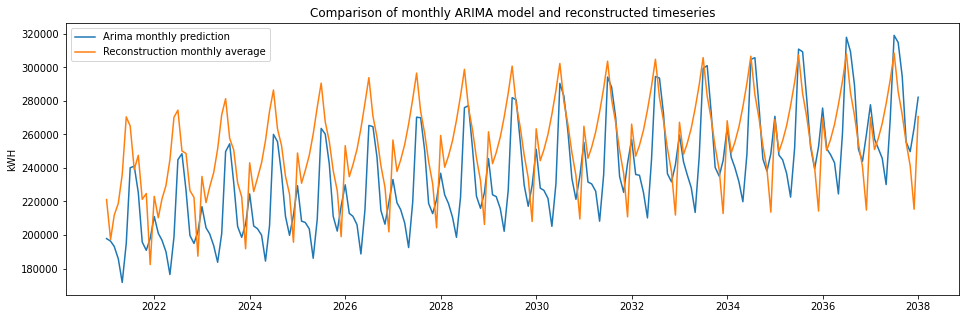

In [56]:
reconstructed = df_re_b['2020-12-31 00:00:00+00:00':'2037-12-31 00:00:00+00:00']
reconstructed_m = reconstructed.resample('M').mean()

plt.figure(figsize=(16,5))
plt.plot(reconstructed_m["reconstructed"], label="Arima monthly prediction")
plt.plot(pred_generation-pred_consumption, label="Reconstruction monthly average")
plt.title("Comparison of monthly ARIMA model and reconstructed timeseries")
plt.ylabel("kWH")
plt.legend()
plt.show()

# print("Mean avg percentage error:", mean_absolute_percentage_error(pred_generation-pred_consumption, reconstructed_m))
# print("Mean absolute error:", mean_absolute_error(pred_generation-pred_consumption, reconstructed_m))

#### Wie oft reicht 10% der Spitzenproduktion nicht aus?
Dafür schauen wir uns die Produktion an und nehmen da das 10te Perzentil an. Um den Verbrauch zu modellieren, suchen wir nach der geeignetsten Verteilung und schauen uns da die Verteilungen der Dichten an, um zu wissen, wie oft diese ausreicht.

In [22]:
spitzenproduktion = data_4h['Strombudget Schweiz'].quantile(q=0.1)
spitzenproduktion

2194683.0195375

In [23]:
f'Wir müssen also schauen, wie oft die Produktion von {spitzenproduktion} KWH nicht ausreicht'

'Wir müssen also schauen, wie oft die Produktion von 2194683.0195375 KWH nicht ausreicht'

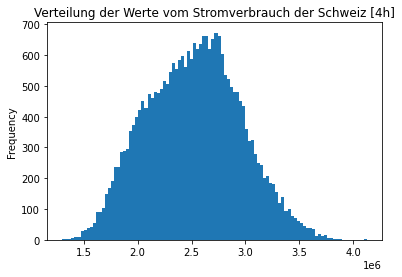

In [59]:
data_4h['Stromverbrauch Schweiz'].copy().plot.hist(bins=100, title='Verteilung der Werte vom Stromverbrauch der Schweiz [4h]')
plt.show()

Es sieht Normalverteilt aus. Das überprüfen wir mit dem QQ-Plot:

Best dist: norm


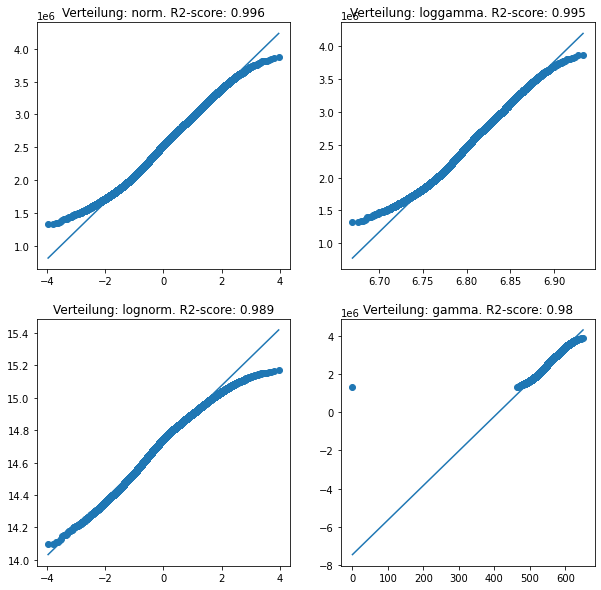

In [60]:
# Create list of distributions to check for (from https://www.acsu.buffalo.edu/~adamcunn/probability/probability.html)
dists = [stats.lognorm, stats.gamma, stats.norm, stats.loggamma]

r2_best, best_dist, r2_list, unusable_dist, error_messages = easy_qq(dists, data_4h['Stromverbrauch Schweiz'])
plt.show()

Eigentlich wäre die beste Verteilung die Normalverteilung. Uns interessieren aber hauptsächlich die unteren Werte und da sehen wir, dass die Lognormal-Verteilung die beste ist. Somit nehmen wir diese.

In [61]:
dist_args = best_dist.fit(data_4h['Stromverbrauch Schweiz'])
best_dist.cdf(spitzenproduktion, *dist_args)

0.22533579487280414

Wir sehen also, dass 10% der Spitzenproduktion in 22.5% der 4h Stunden Intervalle ausreicht.

### Extremwertanalyse Strombilanz Schweiz
Nun schauen wir uns die Extremwerte der Bilanz an.

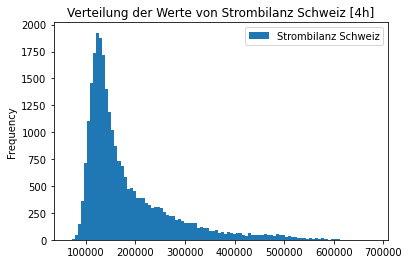

In [62]:
data_4h[['Strombilanz Schweiz']].copy().plot.hist(bins=100, title='Verteilung der Werte von Strombilanz Schweiz [4h]')
plt.show()

Es sieht definitiv logarithmisch aus. Wir schauen uns also Verteilungen an, welche einen Longtail haben. Ebenfalls interessieren uns Extremwerte im niedrigen Bereich. Die Verteilung "Weibull Min" könnte also passend sein.

In [27]:
# Create list of distributions to check for (from https://www.acsu.buffalo.edu/~adamcunn/probability/probability.html)
dists = [stats.lognorm, stats.norm, stats.weibull_min, stats.loggamma]

Best dist: weibull_min


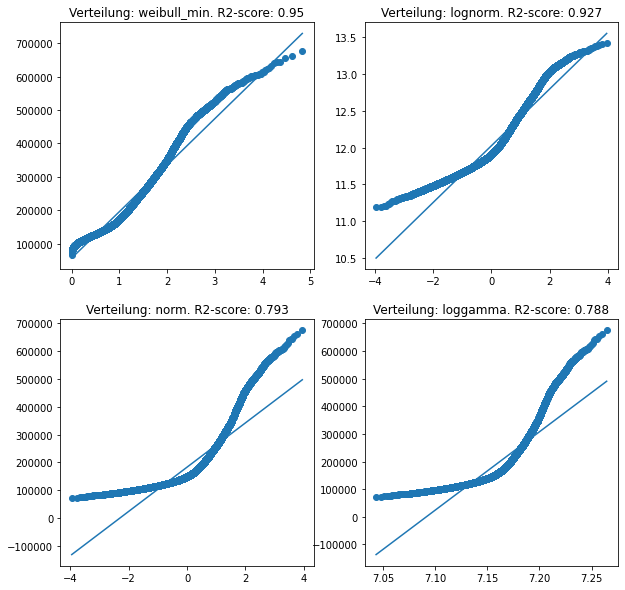

In [28]:
r2_best, best_dist, r2_list, unusable_dist, error_messages = easy_qq(dists, data_4h['Strombilanz Schweiz'])
plt.show()

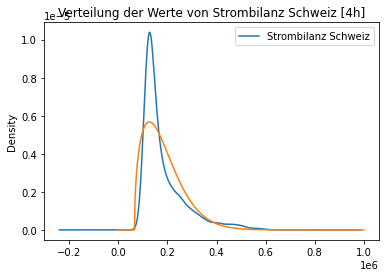

In [65]:
x = np.linspace(0, 1000000, 10000)
distargs = best_dist.fit(data_4h['Strombilanz Schweiz'])

data_4h[['Strombilanz Schweiz']].copy().plot.density(title='Verteilung der Werte von Strombilanz Schweiz [4h]')
plt.plot(x, best_dist.pdf(x, *distargs))
plt.show()

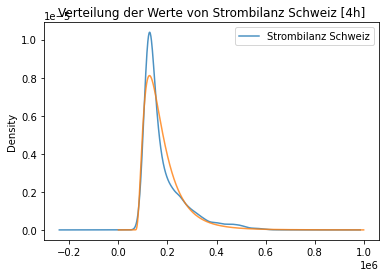

In [66]:
x = np.linspace(0, 1000000, 10000)
distargs = stats.lognorm.fit(data_4h['Strombilanz Schweiz'])
data_4h[['Strombilanz Schweiz']].copy().plot.density(title='Verteilung der Werte von Strombilanz Schweiz [4h]', alpha=0.8)
plt.plot(x, stats.lognorm.pdf(x, *distargs), alpha=0.8)
plt.show()

Es scheint, als wäre die Weibull-Verteilung besser. Für die tieferen Werte ist die Verteilung auch konservativer, da es tieferen Werte mit einer höheren Wahrscheinlichkeit erzeugt.

In [88]:
# fit parameters to data
PERCENT_OF_VALUES = 0.9999
distargs = stats.weibull_min.fit(data_4h['Strombilanz Schweiz'])

In [89]:
f"In {100*(PERCENT_OF_VALUES)}% der 4-Stunden Zeitabschnitte wird die Strombilanz im Intervall {best_dist.interval(PERCENT_OF_VALUES, *distargs)} KMH sein."

'In 99.99% der 4-Stunden Zeitabschnitte wird die Strombilanz im Intervall (65811.72615453733, 685563.5604961496) KMH sein.'

Welcher Wert ist so der niedrigste Wert, welcher mit einer kleinsten Wahrscheinlichkeit erreicht wird?

In [90]:
VALUE = best_dist.interval(PERCENT_OF_VALUES, *distargs)[0]
percent_below = np.round(best_dist.cdf(VALUE, *distargs), 5)*100

In [91]:
f'Das die Bilanz unter den Wert von {VALUE} fällt, hat eine Wahrscheinlichkeit von {percent_below}% pro 4 Stunden Intervall.'

'Das die Bilanz unter den Wert von 65811.72615453733 fällt, hat eine Wahrscheinlichkeit von 0.005% pro 4 Stunden Intervall.'

Wir können dies überprüfen mit den ursprünglichen Daten.

In [92]:
data_4h['Strombilanz Schweiz'].quantile(0.00005)

72096.40500235617

Hier sieht man, dass die Verteilung konservativer ist. 

#### Vergleich mit dem ARIMA-Modell
Wie oft fällt der Wert unter diesen Wert in der Vorraussage über 20 Jahre?

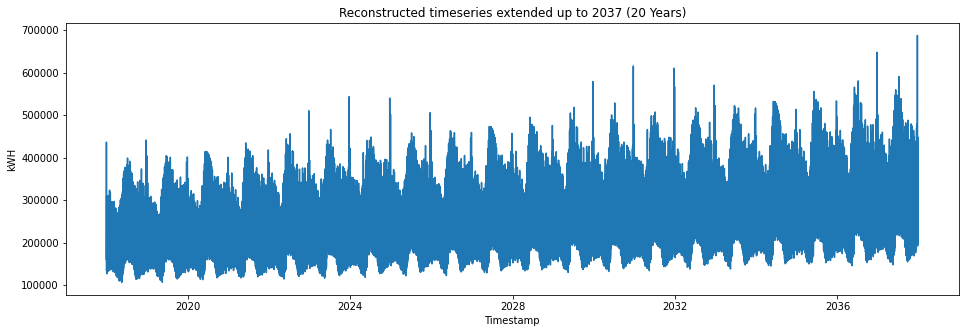

In [77]:
balance_20y = df_re_b["reconstructed"] 

plt.figure(figsize=(16,5))
plt.title("Reconstructed timeseries extended up to 2037 (20 Years)")
plt.plot(balance_20y['2017-12-31 00:00:00+00:00':'2037-12-31 00:00:00+00:00'])
plt.xlabel("Timestamp")
plt.ylabel("kWH")
plt.show()

In [79]:
len(balance_20y[balance_20y<VALUE])

0

Wir sehen, es passiert nie. Nun können wir dies Umkehren und schauen, wie oft der niedrigste Wert der Vorraussage erreicht wird in der Extremwertanalyse.

In [82]:
min_value_20_y_pred = balance_20y.min()
percent_below = np.round(best_dist.cdf(min_value_20_y_pred, *distargs), 5)*100

In [83]:
f'Das die Bilanz unter den Wert von {min_value_20_y_pred} fällt, hat eine Wahrscheinlichkeit von {percent_below}% pro 4 Stunden Intervall.'

'Das die Bilanz unter den Wert von 85117.47897696904 fällt, hat eine Wahrscheinlichkeit von 5.878% pro 4 Stunden Intervall.'